In [1]:
import torchvision as tv
import torch as t
import torchvision.transforms as transforms
from torchvision.transforms import ToPILImage
show=ToPILImage()                         #Tensor转换为Image   利于后续可视化
transform=transforms.Compose([
    transforms.ToTensor(),                #图片转换为Tensor才能进行后续处理
    transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5)),         #括号1：RGB三通道均值  括号2：RGB三通道标准差
    #像素值new=（像素值old-平均值mean）/ 标准差std   
    #注意：0.5只是一个近似的操作，实际上其均值和方差并不是这么多，但是就这个示例而言 影响可不计
    #你用的是自己创建的数据集，从头训练，那最好还是要自己统计自己数据集的mean和std
    #平均值mean求法，所有图片每个像素点求和取均值
    ])
trainset=tv.datasets.CIFAR10(
    root='/media/n/SanDiskSSD/HardDisk/data/CIFAR10/cifar-10-python',
    #trainset testset共用torchvision.datasets.CIFAR10函数，区别在trainset的train为True
    train=True,                           
    download=False,
    transform=transform)

trainloader=t.utils.data.DataLoader(
    trainset,
    batch_size=4,
    shuffle=True,      #洗牌 打乱
    num_workers=1)

testset=tv.datasets.CIFAR10(
    root='/media/n/SanDiskSSD/HardDisk/data/CIFAR10/cifar-10-python',
    train=False,
    download=False,
    transform=transform)

testloader=t.utils.data.DataLoader(
    testset,
    batch_size=4,
    shuffle=False,    #测试集不用打乱  
    num_workers=1)

classes=('plane','car','bird','cat','deer','dog','frog','horse','ship','truck')

In [2]:
(data,label)=trainset[0]
print(classes[label])

frog


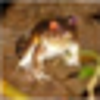

In [3]:
show((data+1)/2).resize((100,100))
##transforms.Normalize处理刚好将0～1转换为-1～+1,这里做复原

      horse        cat        dog        cat


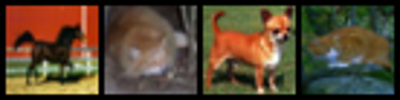

In [4]:
dataiter=iter(trainloader)   #iter()生成迭代器
images,labels=next(dataiter)
print(''.join('%11s'%classes[labels[j]] for j in range(4))) 
# %11s格式化输出，长度为11的字符串，%classes[labels[j]]为对应的变量名
show(tv.utils.make_grid((images+1)/2)).resize((400,100))

In [5]:
a=[1,2,3]
b=iter(a)
###  python2中用*.next()  python3中要用next(*)  否则报错
#b.next()
next(b)


1

In [6]:
labels


tensor([7, 3, 5, 3])

In [7]:
images.size()


torch.Size([4, 3, 32, 32])

In [8]:
#定义模型
import torch.nn as nn
import torch.nn.functional as F
class LeNet(nn.Module):
    def __init__(self):
        super(LeNet,self).__init__()
        self.conv1=nn.Conv2d(3,6,5)
        self.conv2=nn.Conv2d(6,16,5)
        self.fc1=nn.Linear(16*5*5,120)
        self.fc2=nn.Linear(120,84)
        self.fc3=nn.Linear(84,10)
        
    def forward(self,x):
        x=F.max_pool2d(F.relu(self.conv1(x)),(2,2))
        x=F.max_pool2d(F.relu(self.conv2(x)),2)
        x=x.view(x.size()[0],-1)
        x=F.relu(self.fc1(x))
        x=F.relu(self.fc2(x))
        x=self.fc3(x)
        return x

net=LeNet()
print(net)     

LeNet(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)


In [9]:
from torch import optim
#定义损失函数
criterion=nn.CrossEntropyLoss()
#定义优化器
optimizer=optim.SGD(net.parameters(),lr=0.001,momentum=0.9)
#定义网络
#流程：输入数据——>梯度清零——>正向传播/反向传播——>参数更新
for epoch in range(2):
    print('Training start')
    running_loss=0.0
    #enumerate() 函数用于将一个可遍历的数据对象(如列表、元组、字符串、迭代器或其他支持迭代对象)组合为一个索引序列，
    #同时列出数据和数据下标
    for i,data in enumerate(trainloader,0):  #0代表起始位置
        #输入数据
        inputs,labels=data
        #inputs,labels=Variable(inputs),Variable(labels)
        
        #梯度清零
        optimizer.zero_grad()
        #前向 反向传播
        outputs= net(inputs)
        loss=criterion(outputs,labels)
        loss.backward()
        #参数更新
        optimizer.step()
        
        #打印log信息
        running_loss+=loss
        if i%2000 == 1999: #2000次iter(一次iter，一个batch，4张images）打印一次
            print('[%d,%5d] loss:%.3f'\
                 %(epoch+1,i+1,running_loss/2000))
            running_loss=0.0
print('Training finished')
        
                    

Training start
[1, 2000] loss:2.179
[1, 4000] loss:1.830
[1, 6000] loss:1.638
[1, 8000] loss:1.547
[1,10000] loss:1.499
[1,12000] loss:1.435
Training start
[2, 2000] loss:1.373
[2, 4000] loss:1.340
[2, 6000] loss:1.320
[2, 8000] loss:1.295
[2,10000] loss:1.269
[2,12000] loss:1.244
Training finished


实际的label:      cat    ship    ship   plane


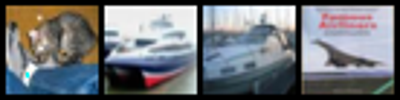

In [10]:
##测试集实际的label   
dataiter=iter(testloader)   #testloader 没有shuffle  所以和书本上一样 但 trainloader有shuffle
images,labels=dataiter.next()
print('实际的label:',''.join('%08s'%classes[labels[j]] for j in range(4)))
show(tv.utils.make_grid(images/2-0.5)).resize((400,100))

In [11]:
##网络预测的label
import torch
outputs=net(images)
_,predicted=torch.max(outputs.data,1)  #注意  _：分数值    predicted：最大分数值对应的位置 
print('预测结果:',''.join('%8s'%classes[predicted[j]] for j in range(4)))

预测结果:     frog    ship    ship   plane


In [12]:
correct=0
total=0
for data in testloader:
    images,labels=data
    outputs=net(images)
    _,predicted=torch.max(outputs.data,1)
    total+=labels.size(0)
    correct+=(predicted==labels).sum()
print('%f%%'%(correct*100/total))

54.000000%
